In [7]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier

## <a name="C4">MODELISATION </a>

In [8]:
data = pd.read_csv('data0.csv')
print('Les dimensions du data training : ', data.shape)
data.head()

Les dimensions du data training :  (307511, 243)


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,1,0,0,0,0,0,0,1,0,0
2,100004,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [10]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [11]:
#scaling the data
scaler = StandardScaler()
X_train = X_train_scaled = scaler.fit_transform(X_train)
X_test = X_test_scaled = scaler.transform(X_test)

##  <a name="C2"> Baseline avec Dummy regressor</a>

In [12]:
model = DummyRegressor(strategy="median")
model.fit(X_train, y_train)
DummyRegressor()

y_pred = model.predict(X_train)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
model.score(X_train, y_train)

-0.08841004440794875

In [14]:
model.score(X_test, y_test)

-0.0860468730134063

In [15]:
y_pred = model.predict(X_test)

In [16]:
print(classification_report(y_test,y_pred));

C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70787
           1       0.00      0.00      0.00      6091

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.85      0.92      0.88     76878



 ## Forêt aléatoire

In [17]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [18]:
#implementation de FerestClassifier
mdl_fra = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
result = mdl_fra.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished


In [19]:
y_pred = mdl_fra.predict(X_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.3s finished


In [20]:
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

In [21]:
mdl_fra.score(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.8s finished


0.9999609769634007

In [22]:
mdl_fra.score(X_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    6.5s finished


0.9207965867998648

In [23]:
y_pred = mdl_fra.predict(X_test)
y_pred

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   11.8s finished


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [24]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70787
           1       1.00      0.00      0.00      6091

    accuracy                           0.92     76878
   macro avg       0.96      0.50      0.48     76878
weighted avg       0.93      0.92      0.88     76878



## XGBoots Classifier

In [25]:
import xgboost
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [26]:
y_pred = model.predict(X_test)

In [27]:
model.score(X_test, y_test)

0.9204063581258618

In [28]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70787
           1       0.47      0.03      0.06      6091

    accuracy                           0.92     76878
   macro avg       0.69      0.51      0.51     76878
weighted avg       0.89      0.92      0.89     76878



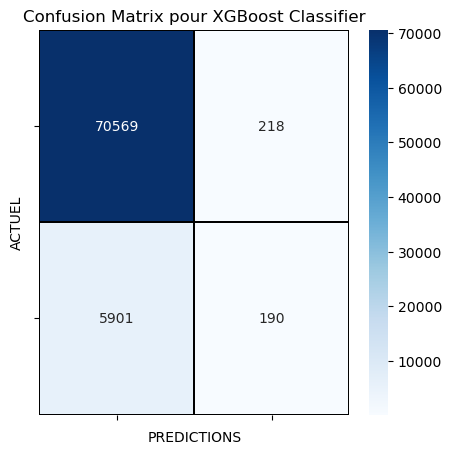

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["", ""]
y_axis_labels = ["", ""]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f",
            ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUEL")
plt.title('Confusion Matrix pour XGBoost Classifier')
plt.show()

In [30]:
import shap
explainer = shap.Explainer(model, X)
shap_values = explainer(X_test)

100%|===================| 76871/76878 [12:48<00:00]        

Les feature EXT_SOURCE_3, EXT_SOURCE_2, AMT_GOODS8_PRICE sont les plus importants en moyenne pour ce modèle

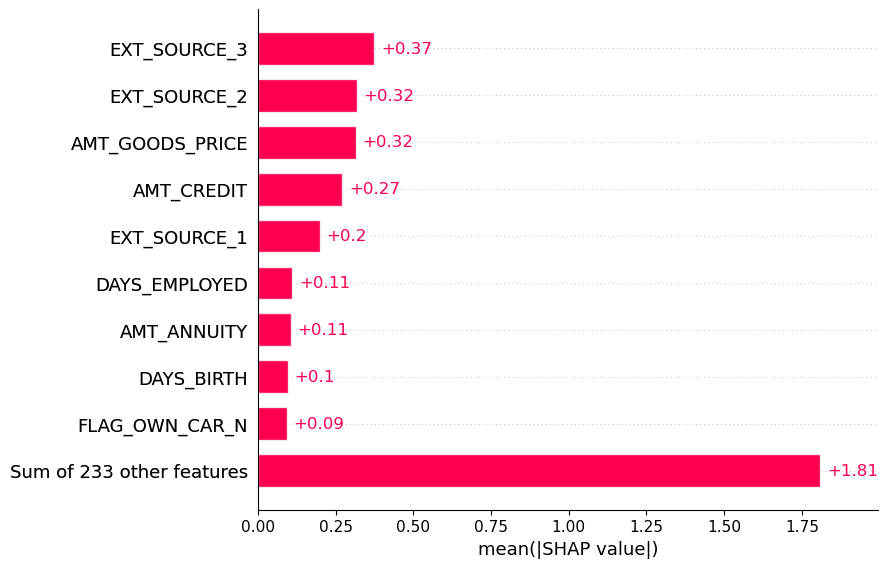

In [31]:
shap.plots.bar(shap_values)

In [66]:
df=pd.read_csv('df_svm.csv') 
df = df.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [67]:
X = df.drop('TARGET', axis = 1)
y = df['TARGET']

##  Support  Vecteurs Machines (SVM)

In [68]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
mdl_svm = SVC(kernel='linear', C=1)

In [71]:
mdl_svm.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [72]:
y_pred = mdl_svm.predict(X_test)

In [73]:
mdl_svm.score(X_test, y_test)

0.8116883116883117

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       140
           1       0.11      0.14      0.12        14

    accuracy                           0.81       154
   macro avg       0.51      0.51      0.51       154
weighted avg       0.84      0.81      0.82       154



In [78]:
X = data.drop('TARGET', axis = 1)
y = data['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

## Utilisation de l'algorithme SMOTE 

La methode SMOTE pour  pour résoudre le problème du déséquilibre des classes.

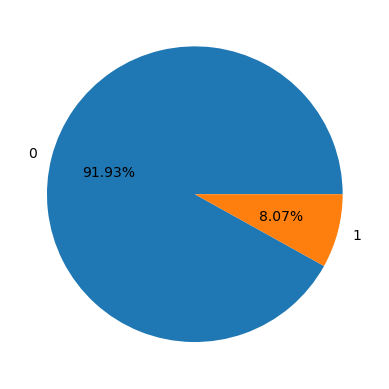

In [79]:
tar = (data['TARGET'].value_counts())/len(data)
plt.pie(tar,labels=tar.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

In [80]:
X_train = X
y_train = y
sm = SMOTE()
X_smote, y_smote = sm.fit_resample(X_train, y_train)
data_sm = pd.concat([X_smote, y_smote], axis=1)

In [81]:
data_sm

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,202500.000000,4.065975e+05,24700.500000,3.510000e+05,0.018801,-9461,-637,-3648.000000,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,270000.000000,1.293502e+06,35698.500000,1.129500e+06,0.003541,-16765,-1188,-1186.000000,...,1,0,0,0,0,0,0,1,0,0
2,100004,0,67500.000000,1.350000e+05,6750.000000,1.350000e+05,0.010032,-19046,-225,-4260.000000,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,135000.000000,3.126825e+05,29686.500000,2.970000e+05,0.008019,-19005,-3039,-9833.000000,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,121500.000000,5.130000e+05,21865.500000,5.130000e+05,0.028663,-19932,-3038,-4311.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565367,255486,0,64741.932342,5.450400e+05,26640.000000,4.500000e+05,0.029090,-14769,-418,-2903.829679,...,0,0,0,0,0,0,0,0,0,1
565368,348752,0,157500.000000,2.974727e+05,22020.591638,2.250000e+05,0.018262,-17642,-214,-2105.172761,...,0,0,0,0,0,0,0,0,0,1
565369,335592,0,205407.043413,6.750000e+05,26065.900487,6.750000e+05,0.024610,-16689,-5867,-7923.375654,...,0,0,0,0,0,0,0,0,0,1
565370,346651,1,107999.819250,6.370047e+05,32333.307854,5.499000e+05,0.015334,-10453,-1670,-1472.023377,...,0,0,0,0,0,0,0,0,0,1


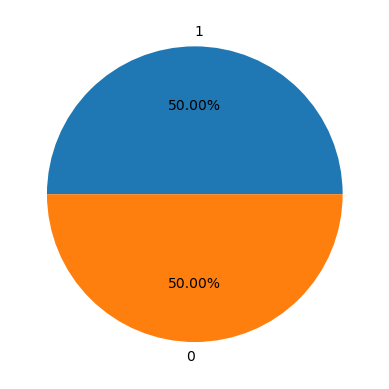

In [82]:
tar = (data_sm['TARGET'].value_counts())/len(data)
plt.pie(tar,labels=tar.index,autopct='%.2f%%')# Diagramme en secteurs
plt.show()

In [83]:
df_sm = data_sm.sample(frac =0.02) 
df_sm.shape

(11307, 243)

In [84]:
df_sm0 = df_sm.sample(frac =0.1) 
df_sm0.shape

(1131, 243)

In [85]:
df_sm0.to_csv('df_sm_svm.csv', index=False)

In [86]:
X = df_sm.drop('TARGET', axis = 1)
y = df_sm['TARGET']
#train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [87]:
#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##  <a name="C2"> Baseline avec Dummy regressor </a>

In [88]:
model = DummyRegressor(strategy="median")
model.fit(X_train, y_train)
DummyRegressor()

y_pred = model.predict(X_train)
print(y_pred)

[1. 1. 1. ... 1. 1. 1.]


In [89]:
model.score(X_train, y_train)

-0.9882766705744432

In [90]:
model.score(X_test, y_test)

-0.9978798586572433

In [91]:
y_pred = model.predict(X_test)
print(y_pred)

[1. 1. 1. ... 1. 1. 1.]


In [92]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1412
           1       0.50      1.00      0.67      1415

    accuracy                           0.50      2827
   macro avg       0.25      0.50      0.33      2827
weighted avg       0.25      0.50      0.33      2827



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Forêt aléatoire

In [93]:
#implementation de FerestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


RandomForestClassifier(n_jobs=-1, random_state=50, verbose=1)

In [94]:
model.score(X_test, y_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9327909444640962

In [95]:
y_pred = model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [96]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1412
           1       0.99      0.87      0.93      1415

    accuracy                           0.93      2827
   macro avg       0.94      0.93      0.93      2827
weighted avg       0.94      0.93      0.93      2827



## XGBoots Classifier

In [97]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [98]:
y_pred = model.predict(X_test)

In [99]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1412
           1       0.99      0.91      0.95      1415

    accuracy                           0.95      2827
   macro avg       0.95      0.95      0.95      2827
weighted avg       0.95      0.95      0.95      2827



In [100]:
confusion_matrix(y_test, y_pred)

array([[1394,   18],
       [ 124, 1291]], dtype=int64)

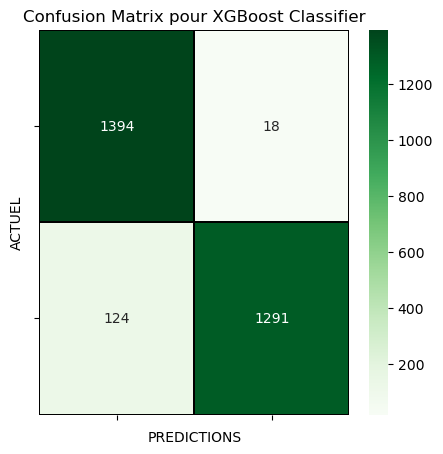

In [101]:
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["", ""]
y_axis_labels = ["", ""]

f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f",
            ax=ax, cmap="Greens", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("PREDICTIONS")
plt.ylabel("ACTUEL")
plt.title('Confusion Matrix pour XGBoost Classifier')
plt.show()

In [102]:
df0 = pd.read_csv('df_sm_svm.csv')
df0.shape

(1131, 243)

In [103]:
X = df0.drop('TARGET', axis = 1)
y = df0['TARGET']

##  Support  Vecteurs Machines (SVM)

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [105]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [106]:
model = SVC(kernel='linear', C=1)

In [107]:
model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [108]:
y_pred = model.predict(X_test)

In [109]:
model.score(X_test, y_test)

0.8586572438162544

In [110]:
print(classification_report(y_test,y_pred));

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       144
           1       0.85      0.86      0.86       139

    accuracy                           0.86       283
   macro avg       0.86      0.86      0.86       283
weighted avg       0.86      0.86      0.86       283



In [33]:
from sklearn.model_selection import GridSearchCV